<img src="pr1.png" />

In [10]:
import cvxpy
import gurobipy
from cvxpy import *
import numpy as np

In [143]:
np.random.seed(42)

# initial matrix
m = np.array([[ 5 , 5 , 10, 10, 10 ],
              [ 5 , 5 , 10, 20, 10 ],
              [ 0 , 5 , 5 , 10,  5 ],
              [ 0 , 0 , 0 , 5 ,  0 ]])

N, M = m.shape
C = N * M

# delta matrix
d = np.ones((N, M)) * 6
d = d - m

# cost to transfer the ground from the (i1, j1) to (i2, j2)
def cost(i1, j1, i2, j2):
    assert(i1 < N and i2 < N and j1 < M and j2 < M and 
           i1 >= 0 and i2 >= 0 and j1 >= 0 and j2 >= 0)
    
    if i1 == i2 and j1 == j2:
        return 1000000
    
    return np.sqrt(np.power(np.abs(i1 - i2), 2) + np.power(np.abs(j1 - j2), 2))

m = m.reshape(C,1)
d = d.reshape(C,1)

f = Int(C * C)
c = np.zeros(C * C)

# fill the cost matrix
for i1 in xrange(N):
    for j1 in xrange(M):
        for i2 in xrange(N):
            for j2 in xrange(M):
                c[(i1 * M + j1) * C + (i2 * M + j2)] = cost(i1, j1, i2, j2)
                
# Each cell can either be only a consumer or a "donor" in my model.
# This simplification just introduces a new cutting plane which doesn't
# affect the global optimum (I had the same result without "donors").
# This restriction gave me more integers when I was trying to solve with 
# the general LP solver.
def pred(x):
    if x < 0:
        return 1
    
    return 0

pd = np.vectorize(pred)
is_donor = pd(d).reshape(C,)

flow_network_constraints = [ (-is_donor[i] * cvxpy.sum_entries(f[i*C:i*C + C]) + \
                             (1 - is_donor[i]) * cvxpy.sum_entries(f[i:C*C:C]) == d[i]) \
                            for i in xrange(C) ]
fnc_not_donors = [ (1 - is_donor[i]) * cvxpy.sum_entries(f[i*C:i*C + C]) == 0 for i in xrange(C) ]
fnc_donors = [ is_donor[i] * cvxpy.sum_entries(f[i:C*C:C]) == 0 for i in xrange(C) ]

flows_are_positive = [ (f[i] >= 0) for i in xrange(C * C) ]

obj = Minimize(c * f)

constraints = flows_are_positive + flow_network_constraints + fnc_not_donors + fnc_donors

#print installed_solvers()

prob = Problem(obj, constraints)
res = prob.solve(feastol=1e-8) # verbose=True, 
print "Result: ", res
eps = 0.0000000001
print "Flows size: ", f.value[np.where( f.value > eps )] 
# print cvxpy.sum_entries(f[13:C*C:C]).value

 Result:  95.4910638371
Flows size:  [[ 1.  1.  1.  1.  4.  1.  3.  2.  1.  1.  1.  5.  6.  2.  1.  3.  4.]]


I've tried several similar min cost max flow models. All of them gave the same result as this one that is constrained to have an integer valued flows.

<img src="pr2.png" />

Each of our clients has a constraint $\sum_j{cf_j} = 1$, where $cf$ is the client/facility arrangement matrix. If there is more than one non-zero $cf_j$ for one client we will take the greatest one and try to branch on it. If each of the clients belongs to exactly one facility than we should also check that the opened/closed facility vector $f$  also got no fractional values. In case it has we will make a branch on it too.

In [71]:
# initialization

import numpy as np
import scipy as sp
from numpy import random
from numpy import matlib
import matplotlib.pyplot as plt
from cvxpy import *
import cvxpy

%matplotlib inline

np.random.seed(1)

C = 20; # number of clients
clients = np.random.rand(2,C); #client positions
F = 15; #number of facilities
facilities = np.random.rand(2,F);

capacities = np.ones((F,))*4; #maximum number of clients per facility

dx = np.matlib.repmat(clients[0,:],F,1) - np.matlib.repmat(facilities[0,:],C,1).transpose();
dy = np.matlib.repmat(clients[1,:],F,1) - np.matlib.repmat(facilities[1,:],C,1).transpose();

assignment_costs = 3*(dx*dx + dy*dy); #the assignment cost is the distance squared

opening_costs = np.ones((F,));

#opening_costs = np.array([1, 2, 1, 2, 1, 1.2, 1.3, 2, 1, 1, 1.4, 2, 1, 1, 1, 1, 1.5, 1.3, 2, 1]);

In [72]:
POS_INF = 1000000L
eps = 1e-8

"""
Solves the problem for the specific node.
Node is identified by some fixed client/facility mapping integer constraints.
And also with opened/closed facilities constraints.

Ex: constr = [({1: (2, 0), 2: (1, 1)}, {4: 0, 5: 1})] - 
    * 1st client doesn't belong to 2nd facility
    * 2nd client belongs to 1st facility
    * 4th facility is closed
    * 5th is opened
"""
def lp_solve(constr):
    global F, C, nodes_visited, clients, facilities, capacities, assignment_costs, opening_costs
    
    # closed facilities
    closed = map(lambda (a,b): a, filter(lambda (a,b): b == 0, constr[1].iteritems()))

    # check if there's enough total capacity of the facilities
    if np.sum(capacities) - np.sum(capacities[closed]) < C: 
        return [POS_INF, []]
    
    f = Variable(F)
    cf = Variable(C, F)
            
    constraints = [ f[i] >= 0 for i in xrange(F) ] + \
                  [ f[i] <= 1 for i in xrange(F) ] + \
                  [ (cvxpy.sum_entries(cf[i,:]) == 1) for i in xrange(C) ] + \
                  [ (cvxpy.sum_entries(cf[:,i]) == f[i] * capacities[i]) for i in xrange(F) ] + \
                  [ cf[i, j] >= 0 for i in xrange(C) for j in xrange(F) ]

    additional_constr = []
    
    for k, v in constr[0].iteritems():
        additional_constr += [ cf[k, v[0]] == v[1] ]
    
    for k, v in constr[1].iteritems():
        additional_constr += [ f[k] == v ]
        
    obj = Minimize(vec(f).T * opening_costs + vec(cf).T * vec(assignment_costs))
    prob = Problem(obj, constraints + additional_constr)
    res = prob.solve()
    eps = 1e-10
    #opened = np.where(f.value > eps)[0]
    
    return [res, cf.value, f.value]

def select_f_frac(f):
    assert(len(f) == F)
    
    mx = -1
    mi = -1
    
    for i in xrange(F):
        if (f[i] <= 1 - eps and f[i] >= eps):
            if mx < f[i]:
                mx = f[i]
                mi = i
    
    return mi
    
def select_frac(x):
    assert(x.shape == (C, F))
    res = 0
    mx = -1
    mi, mj = -1, -1
    
    for i in xrange(C):
        for j in xrange(F):
            if (x[i, j] <= 1 - eps and x[i, j] >= eps):
                if mx < x[i, j]:
                    mx = x[i, j]
                    mi = i
                    mj = j
                
    return (mi, mj)

def branch_and_bound(iterations = 1):
    incumbent_value = POS_INF
    incumbent = 0
    
    queue = [({}, {})]
    
    while queue and iterations > 0:
        iterations -= 1
        node = queue.pop(0)
        res, x, f_val = lp_solve(node)

        if res >= incumbent_value:
            continue
        
        idx = select_frac(x)
        
        if idx == (-1, -1):
            idx = select_f_frac(f_val)
            
            if idx == -1:
                print "UPDATED: ", res
                incumbent_value = res
                incumbent = (x, f_val)
            else:
                nc_0, nc_1 = (node[0].copy(), node[1].copy()), (node[0].copy(), node[1].copy())
                nc_0[1][idx] = 0
                nc_1[1][idx] = 1
                queue.extend([nc_0, nc_1])
                
        else:
            nc_1, nc_0 = (node[0].copy(), node[1].copy()), (node[0].copy(), node[1].copy())
            nc_1[0][idx[0]] = (idx[1], 1)
            nc_0[0][idx[0]] = (idx[1], 0)
            queue.extend([nc_0, nc_1])
        
        print "Node: ", node, "; res: ", res
    print "======================================="
    print "Best result: "
    print incumbent_value
    print "Facilities: ", incumbent[1]
    np.set_printoptions(precision = 1, suppress = True) 
    print "Arrangement: ", incumbent[0]
        
branch_and_bound(1000)

Node:  ({}, {}) ; res:  6.34008178113
Node:  ({}, {9: 0}) ; res:  6.59971092291
Node:  ({}, {9: 1}) ; res:  6.47143727799
Node:  ({}, {8: 0, 9: 0}) ; res:  6.83233192369
Node:  ({}, {8: 1, 9: 0}) ; res:  6.61956835197
Node:  ({7: (12, 0)}, {9: 1}) ; res:  6.47285345256
Node:  ({7: (12, 1)}, {9: 1}) ; res:  6.47143727508
Node:  ({}, {8: 0, 9: 0, 11: 0}) ; res:  6.99791706742
Node:  ({}, {8: 0, 9: 0, 11: 1}) ; res:  6.88514018395
Node:  ({19: (13, 0)}, {8: 1, 9: 0}) ; res:  6.62941848339
Node:  ({19: (13, 1)}, {8: 1, 9: 0}) ; res:  6.61956834728
Node:  ({7: (12, 0)}, {8: 0, 9: 1}) ; res:  6.57099106046
Node:  ({7: (12, 0)}, {8: 1, 9: 1}) ; res:  6.68399621115
Node:  ({7: (12, 1)}, {8: 0, 9: 1}) ; res:  6.56957488384
Node:  ({7: (12, 1)}, {8: 1, 9: 1}) ; res:  6.68258002202
Node:  ({19: (13, 0)}, {8: 0, 9: 0, 11: 0}) ; res:  7.00776718128
Node:  ({19: (13, 1)}, {8: 0, 9: 0, 11: 0}) ; res:  6.99791704521
Node:  ({}, {8: 0, 9: 0, 11: 1, 14: 0}) ; res:  7.03751985683
Node:  ({}, {8: 0, 9: 0,

$7.9$ vs GUROBI's $7.57$.

<img src="pr3.png" />

In [49]:
import numpy as np
from cvxpy import *
import cvxpy
import matplotlib as plt

from timeit import default_timer as timer

%matplotlib inline

np.random.seed(1)
ex20 =  np.random.rand(20, 20)

def ILPuniform(pref, uf = True):
    N = pref.shape[0]
    assert (pref.shape[0] == pref.shape[1])
    pref = np.array(pref)
    
    if not uf:
        for i in xrange(N):
            for j in xrange(N):
                pref[i, j] = np.round(pref[i, j])
    
    for i in xrange(N):
        for j in xrange(N):
            pref[i, j] = pref[j, i]
            
    start_time = timer()
    

    f = Int(N, N)

    constraints = [ (cvxpy.sum_entries(f[i,:]) == 1) for i in xrange(N) ] + \
                  [ (f[i, j] == f[j, i]) for i in xrange(N) for j in xrange(N) ] + \
                  [ f[i, j] >= 0 for i in xrange(N) for j in xrange(N) ] + \
                  [ f[i, i] == 0 for i in xrange(N)]

    obj = Minimize(-vec(pref).T * vec(f))
    prob = Problem(obj, constraints)
    res = prob.solve()
    time_delta = timer() - start_time
    
    return res, time_delta

ex40, ex60 = [np.random.rand(40, 40), np.random.rand(60, 60)]
ex20b = np.array(ex20) # matrix we will use further

for i in xrange(20):
    for j in xrange(20):
        ex20b[i, j] = ex20b[j, i]

res = [ILPuniform(ex20), ILPuniform(ex40), ILPuniform(ex60)]
# print 'Time for N = 20, uniform: ', res[0][1], 's'
# print 'Time for N = 40, uniform: ', res[1][1], 's'
# print 'Time for N = 60, uniform: ', res[2][1], 's'

In [50]:
import pandas as pd
pd.DataFrame(ex20b)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.417022,0.800745,0.988861,0.102334,0.883306,0.326645,0.019880,0.556240,0.239848,0.629718,0.950176,0.176196,0.315245,0.750022,0.879998,0.811859,0.415849,0.866608,0.300248,0.441904
1,0.800745,0.968262,0.748166,0.414056,0.623672,0.527058,0.026211,0.136455,0.493770,0.210174,0.556653,0.332064,0.892889,0.858314,0.903842,0.874962,0.616685,0.949806,0.143006,0.581577
2,0.988861,0.748166,0.280444,0.694400,0.750942,0.885942,0.028306,0.059918,0.619956,0.752756,0.915606,0.130997,0.577857,0.755082,0.662720,0.688413,0.233666,0.826407,0.901308,0.989752
3,0.102334,0.414056,0.694400,0.414179,0.348898,0.357270,0.246211,0.121343,0.828981,0.066536,0.641566,0.809491,0.184010,0.698057,0.270208,0.569494,0.101967,0.854115,0.541559,0.203906
4,0.883306,0.623672,0.750942,0.348898,0.269928,0.908535,0.860028,0.044552,0.156791,0.260315,0.390008,0.344737,0.787929,0.864479,0.252367,0.160971,0.515857,0.098743,0.974740,0.247733
5,0.326645,0.527058,0.885942,0.357270,0.908535,0.623360,0.538831,0.107494,0.018576,0.804755,0.485991,0.940107,0.612031,0.322681,0.854898,0.466880,0.477141,0.651304,0.636604,0.262173
6,0.019880,0.026211,0.028306,0.246211,0.860028,0.538831,0.552822,0.225709,0.070022,0.193434,0.604310,0.582014,0.053909,0.670789,0.527715,0.345172,0.152672,0.703517,0.993913,0.750172
7,0.556240,0.136455,0.059918,0.121343,0.044552,0.107494,0.225709,0.712989,0.486345,0.639461,0.549548,0.878832,0.420194,0.450874,0.802161,0.225040,0.621806,0.610241,0.546071,0.456975
8,0.239848,0.493770,0.619956,0.828981,0.156791,0.018576,0.070022,0.486345,0.606329,0.524670,0.926181,0.844734,0.679069,0.382103,0.572489,0.592512,0.544010,0.799615,0.526426,0.056929
9,0.629718,0.210174,0.752756,0.066536,0.260315,0.804755,0.193434,0.639461,0.524670,0.924808,0.918733,0.905392,0.918602,0.410811,0.733143,0.312270,0.654137,0.034571,0.135428,0.508516


In [13]:
res = [ILPuniform(ex20b), ILPuniform(ex40, False)]
print 'Time for N = 20, uniform: ', res[0][1], 's'
print 'Time for N = 40, uniform: ', res[1][1], 's'
#print 'Time for N = 60, uniform: ', res[2][1], 's'

Time for N = 20, uniform:  0.469834089279 s
Time for N = 40, uniform:  22.2096951008 s


In [43]:
import networkx as nx

def plot_graph(X, n):
    eps = 1e-8
    adj_matrix = np.zeros((n, n), dtype=float)

    # plot graph
    for i in xrange(n):
        for j in xrange(n):
            if np.abs(X[i, j]) > eps and np.abs(X[i, j] - 1) > eps: 
                adj_matrix[i, j] = 1

    rows, cols = np.where(np.abs(adj_matrix) > 1e-5)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    nx.draw(gr, node_size=500, with_labels=True)

As we can see binary case is much more time consuming than with the randomly uniformed relation matrix.

In [15]:
res[0][0] # result we will be trying to reach

-17.93963595514698

Now lets make a simple LP solution and then add a separating cut generator.

In [44]:
eps = 1e-8

# returns number of fractional values and their positions in the
# matrix
def count_frac(f):
    global eps
    N = f.shape[0]
    assert(N == f.shape[1])
    res = 0
    vals = []
    
    for i in xrange(N):
        for j in xrange(i, N):
            if (f[i, j] <= 1 - eps and f[i, j] >= eps):
                res += 1
                vals += [(i, j)]
                
    return res, vals

# solves the dormitory problem with the LP solver
def LPsolve(pref, f, additional_constraints = []):
    N = pref.shape[0]
    assert(pref.shape[1] == N)
    pref = np.array(pref)

    start_time = timer()
    
    constraints = [ (cvxpy.sum_entries(f[i,:]) == 1) for i in xrange(N) ] + \
                  [ (f[i, j] == f[j, i]) for i in xrange(N) for j in xrange(N) ] + \
                  [ f[i, j] >= 0 for i in xrange(N) for j in xrange(N) ] + \
                  [ f[i, i] == 0 for i in xrange(N)]

    obj = Minimize(-vec(pref).T * vec(f))
    prob = Problem(obj, constraints + additional_constraints)
    res = prob.solve()
    time_delta = timer() - start_time
    
    return res, time_delta, f.value

f = Variable(20, 20)
res, tm, fres = LPsolve(ex20b, f) # ex20 has integer solution

print count_frac(fres)[0] / 2
# print zip(count_frac(fres)[1], map(lambda (i,j): np.round(fres[i,j], decimals = 3), count_frac(fres)[1]))

7


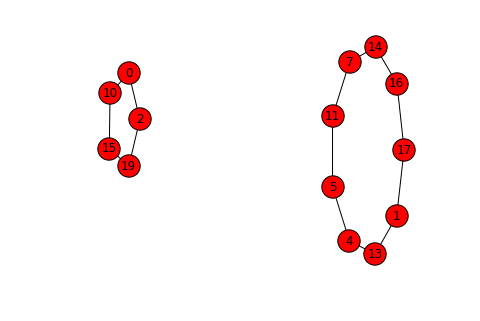

In [45]:
plot_graph(fres, 20)

Ok we've got not so much fractional numbers. Lets draw the graph.

<img src="photo.jpg" />

Lets now introduce a cutting plane that will remove all the cycles.
If there is a cycle $\{x_1, x_2, \dots, x_n\}$ in the resulting graph with odd $n$ than the following constraint will be a cutting plane: $\{f_{x_1, x_2} + f_{x_2, x_3} + \dots + f_{x_{n-1}, x_n} + f_{x_n, x_1} \leq \lfloor \frac{n}{2} \rfloor\}$

In [46]:
def cycles_constraints(fres, f):
    verts = count_frac(fres)[1]

    n = len(verts)
    cs = []
    
    taken = np.zeros(n)
    
    while True:
        start = -1
        
        for i in xrange(n):
            if taken[i] == 0:
                start = i
                taken[i] = 1
                break
                
        if start == -1:
            break
        
        t = verts[start][1]
        start = verts[start][0]
        cond = f[start, t] 
        ln = 1
        
        while t != start:
            for i in xrange(n):
                if taken[i] == 0: 
                    if verts[i][0] == t:
                        cond += f[t, verts[i][1]]
                        taken[i] = 1
                        t = verts[i][1]
                        ln += 1
                    elif verts[i][1] == t:
                        cond += f[t, verts[i][0]]
                        taken[i] = 1
                        t = verts[i][0]
                        ln += 1
            
        cs = cs + [ (cond <= ln / 2) ]
    
    return cs

for i in xrange(10):
    cs = cycles_constraints(fres, f)
    print 'Cycles found: ', len(cs)
    res, tm, fres = LPsolve(ex20, f, cs)
    print 'Non integers left: ', count_frac(fres)[0]    
    if count_frac(fres)[0] == 0:
        break


Cycles found:  2
Non integers left:  0


In [47]:
print "Result: ", res, "; Time: ", tm

round_matrix = np.array(fres)
N = 20
for i in xrange(N):
    for j in xrange(N):
        if round_matrix[i][j] < 1 - eps:
            round_matrix[i][j] = 0
        else:
            round_matrix[i][j] = 1
            
print ex20b.reshape(1, N*N).dot(round_matrix.reshape(N*N, 1))

Result:  -17.1824248752 ; Time:  0.408329963684
[[ 17.37791999]]


After rounding we got slightly better result.

In [41]:
import pandas as pd

pd.DataFrame(round_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
8,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
